In [2]:
# Nếu chưa có thư viện thì run cell này
!pip install mediapipe
!pip install pandas
!pip install numpy
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 12.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import and Install Dependencies

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read feed
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
#         # Draw landmarks
#         draw_styled_landmarks(image, results)

#         # Show to screen
#         cv2.imshow('OpenCV Feed', image)

#         # Break gracefully
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

# 3. Setup Folders for Collection

In [ ]:
# Path for exported data, numpy arrays
# DATA_PATH = os.path.join('./Data')
DATA_PATH = os.path.join('./drive/MyDrive/PBL5/Data/')

# Actions that we try to detect
actions = np.array(
    ['Bye', 'Fine', 'Good', 'Hello', 'I', 'You', 'Love', 'None']
    )

# Path for exported data, numpy arrays
# DATASET_PATH = os.path.join('./Data')



# 4. Extract Keypoint Values

In [ ]:
list_num_frames  = []
for class_index, class_name in enumerate(actions):
    files_list = os.listdir(os.path.join(DATA_PATH, class_name))
    # Iterate through all the files present in the files list.
    for file_name in files_list:
        # print(file_name)
        # Get the complete video path.
        video_file_path = os.path.join(
            DATA_PATH, class_name, file_name)
        cap = cv2.VideoCapture(video_file_path)
        num_frames = 0
        while True:
            num_frames += 1
            rt, f = cap.read()
            if not rt:
                break
        list_num_frames.append(num_frames)
        cap.release()


Text(0.5, 1.0, 'SỐ LƯỢNG FRAME MỖI HÀNH ĐỘNG')

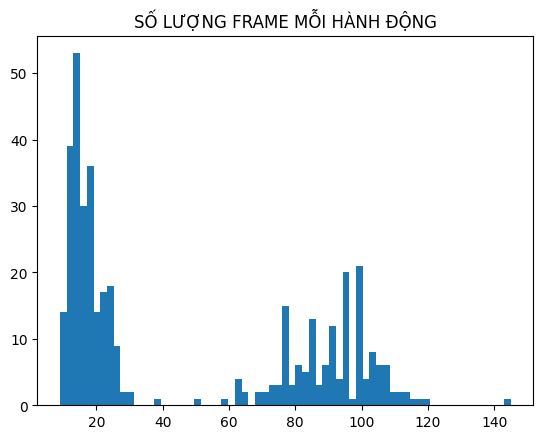

In [ ]:
plt.hist(list_num_frames, bins=len(set(list_num_frames)))
plt.title('SỐ LƯỢNG FRAME MỖI HÀNH ĐỘNG')

In [ ]:
sequence_length = 10

In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*4)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*4)
    return np.concatenate([pose, lh, rh])

In [ ]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [ ]:
def frames_extraction(video_path, rev=False, angle=0):
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = 0
    s, f = video_reader.read()
    while s:
        s, f = video_reader.read()
        video_frames_count += 1
    video_reader.release()

    if video_frames_count < sequence_length:
        return []
    
    skip_frames_window = max(int(video_frames_count/sequence_length), 1)

    # Danh sách chứa các frame sẽ lấy
    video_keypoints = []

    cap = cv2.VideoCapture(video_path)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for frame_counter in range(sequence_length):
            cap.set(cv2.CAP_PROP_POS_FRAMES,
                    frame_counter * skip_frames_window)
            
            ret, frame = cap.read()
            if rev:
                frame = cv2.flip(frame, 1)
            if angle:
                frame = rotate_image(frame, angle=angle)

            if not ret:
                # cap = cv2.VideoCapture(video_path)
                print('eror')
                continue
                # break

            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)   

            keypoints = extract_keypoints(results)
            video_keypoints.append(keypoints)
            # cv2.imshow('OpenCV Feed', cv2.flip(image, 1))
            if cv2.waitKey(1) == ord('e'):
                return

    return video_keypoints


In [ ]:
rs = frames_extraction('./Data/2023-04-09 13_04_06.avi', True)
cv2.destroyAllWindows()


In [ ]:
np.shape(rs)

(0,)

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
def create_dataset():
    features = []
    labels = []

    for class_index, class_name in enumerate(actions):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATA_PATH, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # print(file_name)
            try:
                video_file_path = os.path.join(
                    DATA_PATH, class_name, file_name)

                video_keypoints = frames_extraction(video_file_path)
                if len(video_keypoints) == sequence_length:
                    features.append(video_keypoints)
                    labels.append(class_index)

                # flip
                video_keypoints = frames_extraction(video_file_path, True)
                if len(video_keypoints) == sequence_length:
                    features.append(video_keypoints)
                    labels.append(class_index)
                
                
                # random rotate
                video_keypoints = frames_extraction(video_file_path, True, np.random.randint(10, 30))
                if len(video_keypoints) == sequence_length:
                    features.append(video_keypoints)
                    labels.append(class_index)
                
                video_keypoints = frames_extraction(video_file_path, True, np.random.randint(-30, -10))
                if len(video_keypoints) == sequence_length:
                    features.append(video_keypoints)
                    labels.append(class_index)
                
            except:
                continue

        cv2.destroyAllWindows()


    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels


In [ ]:
features, labels = create_dataset()



In [ ]:
np.savez_compressed(f'{DATA_PATH}/data_rich.npz', features=features, labels=labels)

# 6. Preprocess Data and Create Labels and Features

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp


In [4]:
# Path for exported data, numpy arrays
# DATA_PATH = os.path.join('./Data')
DATA_PATH = os.path.join('./drive/MyDrive/PBL5/Data/')

# Actions that we try to detect
actions = np.array(
    ['Bye', 'Fine', 'Good', 'Hello', 'I', 'You', 'Love', 'None']
    )
sequence_length = 10
# Path for exported data, numpy arrays
# DATASET_PATH = os.path.join('./Data')

In [5]:
actions = np.array(
    ['Bye', 'Fine', 'Good', 'Hello', 'I', 'You', 'Love', 'None']
    )
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Bye': 0,
 'Fine': 1,
 'Good': 2,
 'Hello': 3,
 'I': 4,
 'You': 5,
 'Love': 6,
 'None': 7}

In [9]:
data = np.load(f'{DATA_PATH}/data_rich.npz')
X = data['features']
labels = data['labels']

In [11]:
X.shape

(1560, 10, 300)

In [12]:
y = to_categorical(labels).astype(int)

In [13]:
y.shape

(1560, 8)

(array([32., 31., 40., 38., 42., 42., 45., 42.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

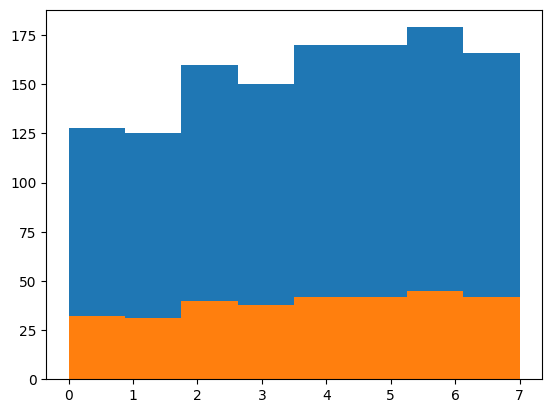

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the indices for splitting
train_idx, test_idx = next(splitter.split(X, y))

# Split the data into train and test sets
X_train_val = X[train_idx]
X_test = X[test_idx]
y_train_val = y[train_idx]
y_test = y[test_idx]
plt.hist(np.argmax(y_train_val, 1), bins=8, label=label_map)
plt.hist(np.argmax(y_test, 1), bins=8, label=label_map)

(array([32., 31., 40., 37., 43., 43., 45., 41.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

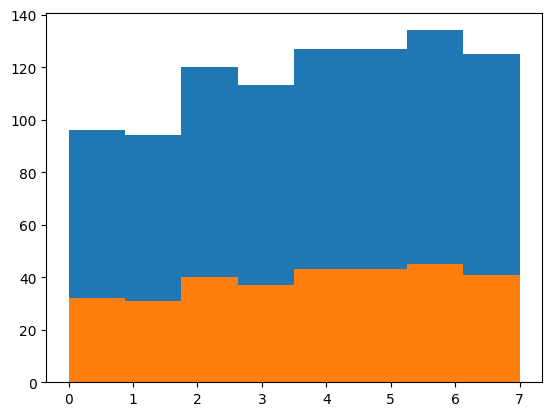

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the splitter
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

# Get the indices for splitting
train_idx, val_idx = next(splitter2.split(X_train_val, y_train_val))

# Split the data into train and val sets
X_train = X_train_val[train_idx]
X_val = X_train_val[val_idx]
y_train = y_train_val[train_idx]
y_val = y_train_val[val_idx]
plt.hist(np.argmax(y_train, 1), bins=len(actions), label=label_map)
plt.hist(np.argmax(y_val, 1), bins=len(actions), label=label_map)

# 7. Build and Train LSTM Neural Network

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [71]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(sequence_length,X.shape[-1])))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

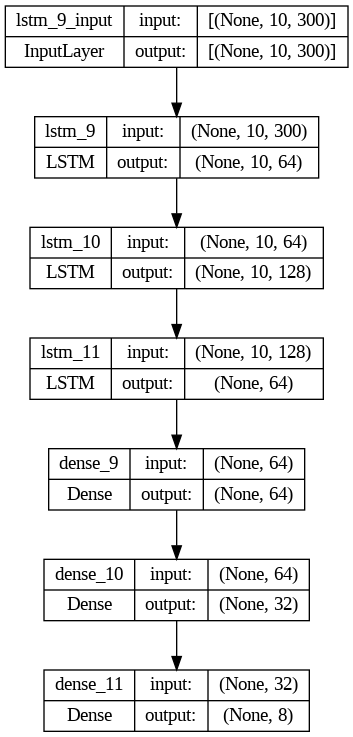

In [72]:
from keras.utils import plot_model

# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 64)            93440     
                                                                 
 lstm_10 (LSTM)              (None, 10, 128)           98816     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                                 
Total params: 248,168
Trainable params: 248,168
Non-tr

In [77]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [78]:
epoch = 500
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping_callback_acc = EarlyStopping(monitor = 'val_loss', patience = epoch / 5, mode = 'min', restore_best_weights = True)
model_history = model.fit(x = X_train, y = y_train, epochs = 500, shuffle = True, validation_data=[X_val, y_val], batch_size=4, callbacks = [early_stopping_callback_acc])

Epoch 1/500
234/234 [==============================] - 9s 23ms/step - loss: 1.5828 - categorical_accuracy: 0.4562 - val_loss: 1.2487 - val_categorical_accuracy: 0.4776
Epoch 2/500
234/234 [==============================] - 7s 29ms/step - loss: 1.0936 - categorical_accuracy: 0.6036 - val_loss: 0.8988 - val_categorical_accuracy: 0.6859
Epoch 3/500
234/234 [==============================] - 5s 20ms/step - loss: 0.6902 - categorical_accuracy: 0.7382 - val_loss: 0.6704 - val_categorical_accuracy: 0.8365
Epoch 4/500
234/234 [==============================] - 5s 21ms/step - loss: 0.4908 - categorical_accuracy: 0.8141 - val_loss: 0.5062 - val_categorical_accuracy: 0.8365
Epoch 5/500
234/234 [==============================] - 7s 30ms/step - loss: 0.4747 - categorical_accuracy: 0.8173 - val_loss: 0.7913 - val_categorical_accuracy: 0.6987
Epoch 6/500
234/234 [==============================] - 5s 20ms/step - loss: 0.4552 - categorical_accuracy: 0.8237 - val_loss: 0.3604 - val_categorical_accuracy:

In [79]:
# path_weight = './weights_1681109498.3648455.h5'
# model = tf.keras.models.load_model(path_weight)
model.evaluate(X_test, y_test)

10/10 [==============================] - 1s 13ms/step - loss: 0.0281 - categorical_accuracy: 0.9904


[0.028110980987548828, 0.9903846383094788]

In [80]:
import time
path_weight =f'{DATA_PATH}/weight_rich{time.time()}.h5'
model.save(path_weight)

# 10. Evaluation using Confusion Matrix and Accuracy

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [82]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, color_1='blue', color_2='red'):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, color_1, label = metric_name_1)
    plt.plot(epochs, metric_value_2, color_2, label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

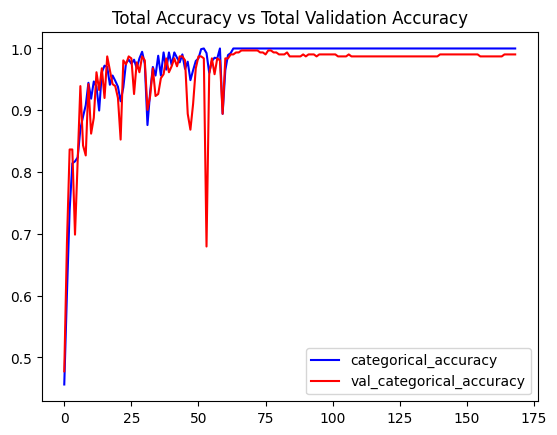

In [83]:
plot_metric(model_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')

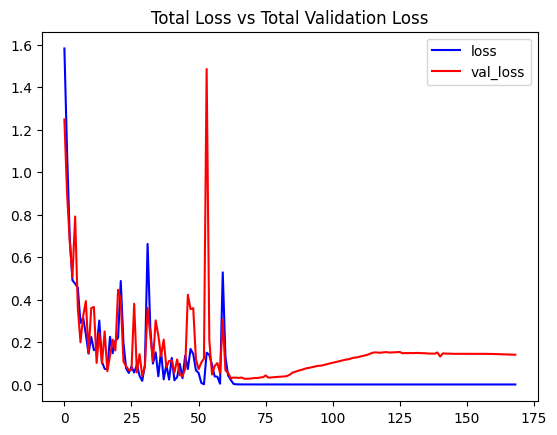

In [85]:
plot_metric(model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [86]:
model = tf.keras.models.load_model(path_weight)
yhat = model.predict(X_test)

10/10 [==============================] - 1s 14ms/step


In [87]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(y_true=ytrue, y_pred=yhat)


0.9903846153846154

<Axes: >

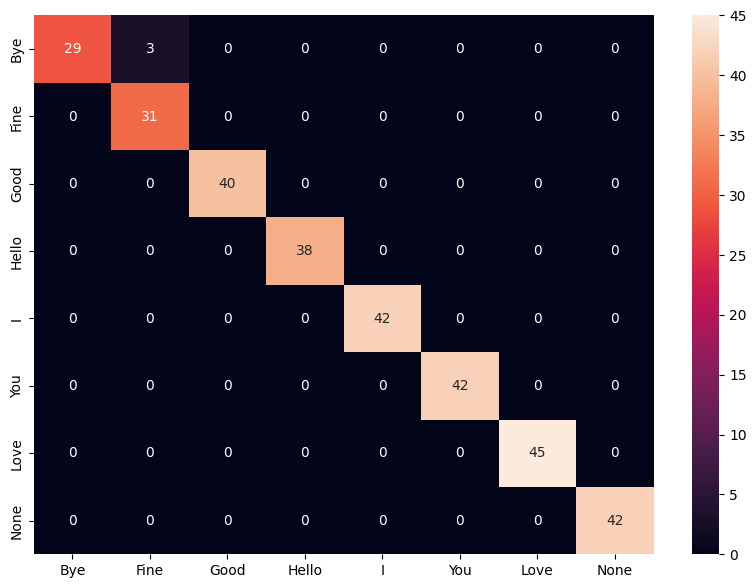

In [88]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


array = confusion_matrix(ytrue, yhat)
df_cm = pd.DataFrame(array, index = [i for i in actions],
                  columns = [i for i in actions])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# 11. Test in Real Time

In [67]:
from scipy import stats
import threading
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [68]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    # for num, prob in enumerate(res[6:]):
    #     cv2.rectangle(output_frame, (input_frame.shape[1]-120,60+num*40), (input_frame.shape[1]-120+int(prob*100), 90+num*40), colors[num%3], -1)
    #     cv2.putText(output_frame, actions[num+6], (input_frame.shape[1]-120, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
# path_weight = './weights_1681109498.3648455.h5'
model = tf.keras.models.load_model(path_weight)

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                        sequence = []


            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()